# CSS 342 Lab 3 Report

Randy Halim <br/>
UWB

In [1]:
# install prerequisite libraries to work with .csv files for graphs
%pip install numpy matplotlib pandas pyarrow statsmodels
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Data Collection

To collect information about our sorting algorithm implementations, a shell script was created to execute the
`Sorter` binary created from our C++ files. In short, this shell script did the following:

1. (re)create a file called `results.csv`. This is where results from the runs of our sorting algorithms are
   stored.
2. define two arrays (sample sizes); a small array (for $O(n^2)$ and related operations) and a large array
   (for more optimized operations).
3. for each sorting algorithm, run a loop 3 times for randomly ordered elements of a vector (array).

This script is useful since (assuming nothing crashes) you can run this in the background at the UWB CSS Lab
machine while it collects the data. The script can be found under `./Sorter.sh` and runs on any linux shell (e.g. bash)

Once we have our data, we need to parse it. We will use `pandas` to parse our .csv file, and plot it with
`matplotlib`:

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from IPython.display import display

In [3]:
# read in the .csv file
df = pd.read_csv("results.csv")
df['ArrayType'] = df['ArrayType'].str.strip()
display(df.columns) # display headers of the csv file
display(df.count()) # count number of rows

# extract each type of sort
bubble_sort = df.loc[df['Type'] == 'BubbleSort']
merge_sort = df.loc[df['Type'] == 'MergeSort']
insertion_sort = df.loc[df['Type'] == 'InsertionSort']
quick_sort = df.loc[df['Type'] == 'QuickSort']
shell_sort = df.loc[df['Type'] == 'ShellSort']

Index(['Type', 'Count', 'ArrayType', 'Time'], dtype='object')

Type         408
Count        408
ArrayType    408
Time         408
dtype: int64

Our collection script uses two different sets of array sizes to run the sorting algorithims against.

```sh
runsizes=(100 1000 5000 10000 50000 100000 500000 1000000) # for expected runtimes better than O(n^2)
runsizes=(100 1000 5000 10000 50000) # for O(n^2) and related worst-case expected runtimes
```

Let us view the runtimes of each sorting algorithm as a scatterplot. Each scatterplot will have four different
colored markers, which represent the four different initial array configurations:

- `random`: randomly shuffle elements in the array
- `ordered`: sequentially order the elements
- `reversed`: same as ordered, but inserted in reverse order
- `partial`: starts the same as ordered, but a random subset of the array is shuffled

Each implementation of the array configurations can be found in `Sorter.cpp` starting at line 51.

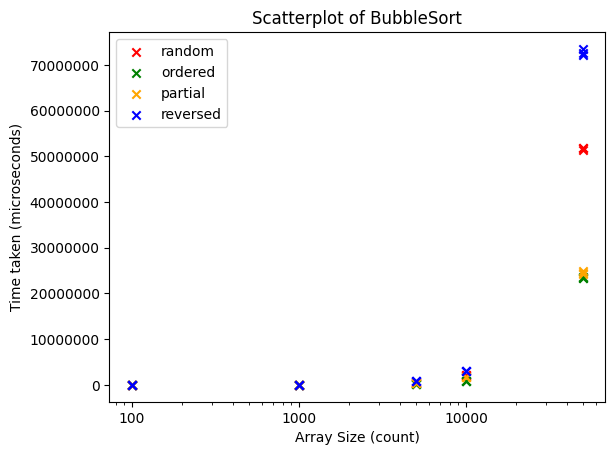

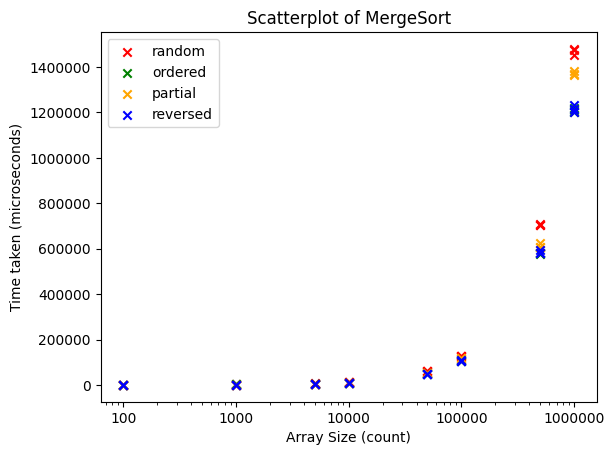

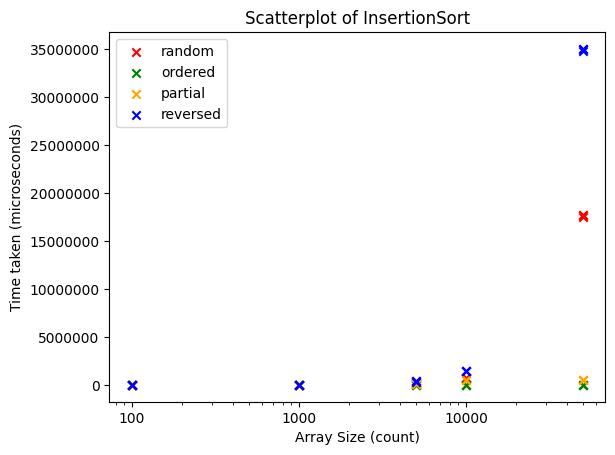

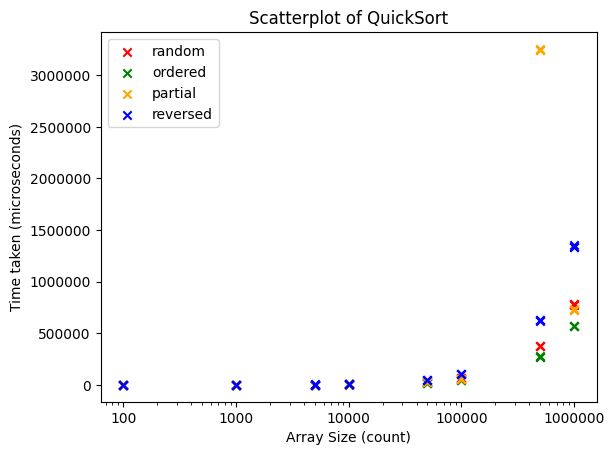

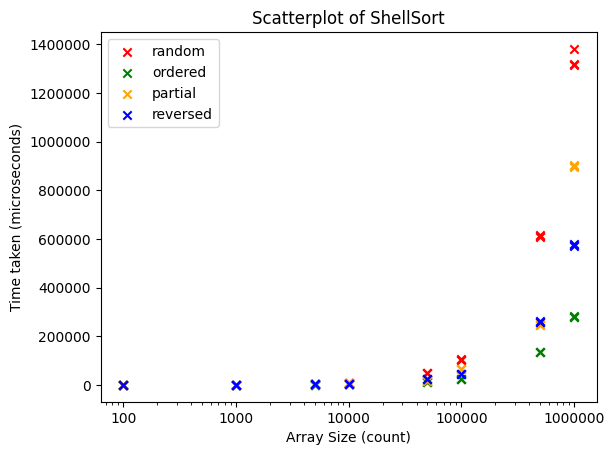

In [4]:
# function to help generate graphs easily, reduces python boilerplate

def generate_graph(df, label):
    colors = { 'random': 'red', 'ordered': 'green', 'partial': 'orange', 'reversed': 'blue' }
    fig, ax = plt.subplots()

    for type, color in colors.items():
        df_category = df.loc[df['ArrayType'] == type]
        ax.scatter(df_category['Count'], df_category['Time'], color=color, label=type, marker='x')

    ax.legend(title='Inital Array Type')

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    
    plt.title('Scatterplot of ' + label)
    plt.legend()
    plt.xlabel('Array Size (count)')
    plt.ylabel('Time taken (microseconds)')

    plt.show()

# now generate and show scatterplots
generate_graph(bubble_sort, 'BubbleSort')
generate_graph(merge_sort, 'MergeSort')
generate_graph(insertion_sort, 'InsertionSort')
generate_graph(quick_sort, 'QuickSort')
generate_graph(shell_sort, 'ShellSort')

For readability, these graphs **x-axis** are on a $\log$ scale.

That is a lot of datapoints. To make this easier, we shall average the runtimes for each case, and display it as a line graph.

In [5]:
def calculate_mean(df):
    averages = df.groupby(['Count', 'ArrayType'])['Time'].mean()
    averages = averages.reset_index()
    return averages

bubblesort_avg = calculate_mean(bubble_sort)
mergesort_avg = calculate_mean(merge_sort)
insertionsort_avg = calculate_mean(insertion_sort)
quicksort_avg = calculate_mean(quick_sort)
shellsort_avg = calculate_mean(shell_sort)

# Average case performance of sorting algorithms

Let us calculate the average for each sorting algorithm where we passed it a `random` array, and display it in a graph:

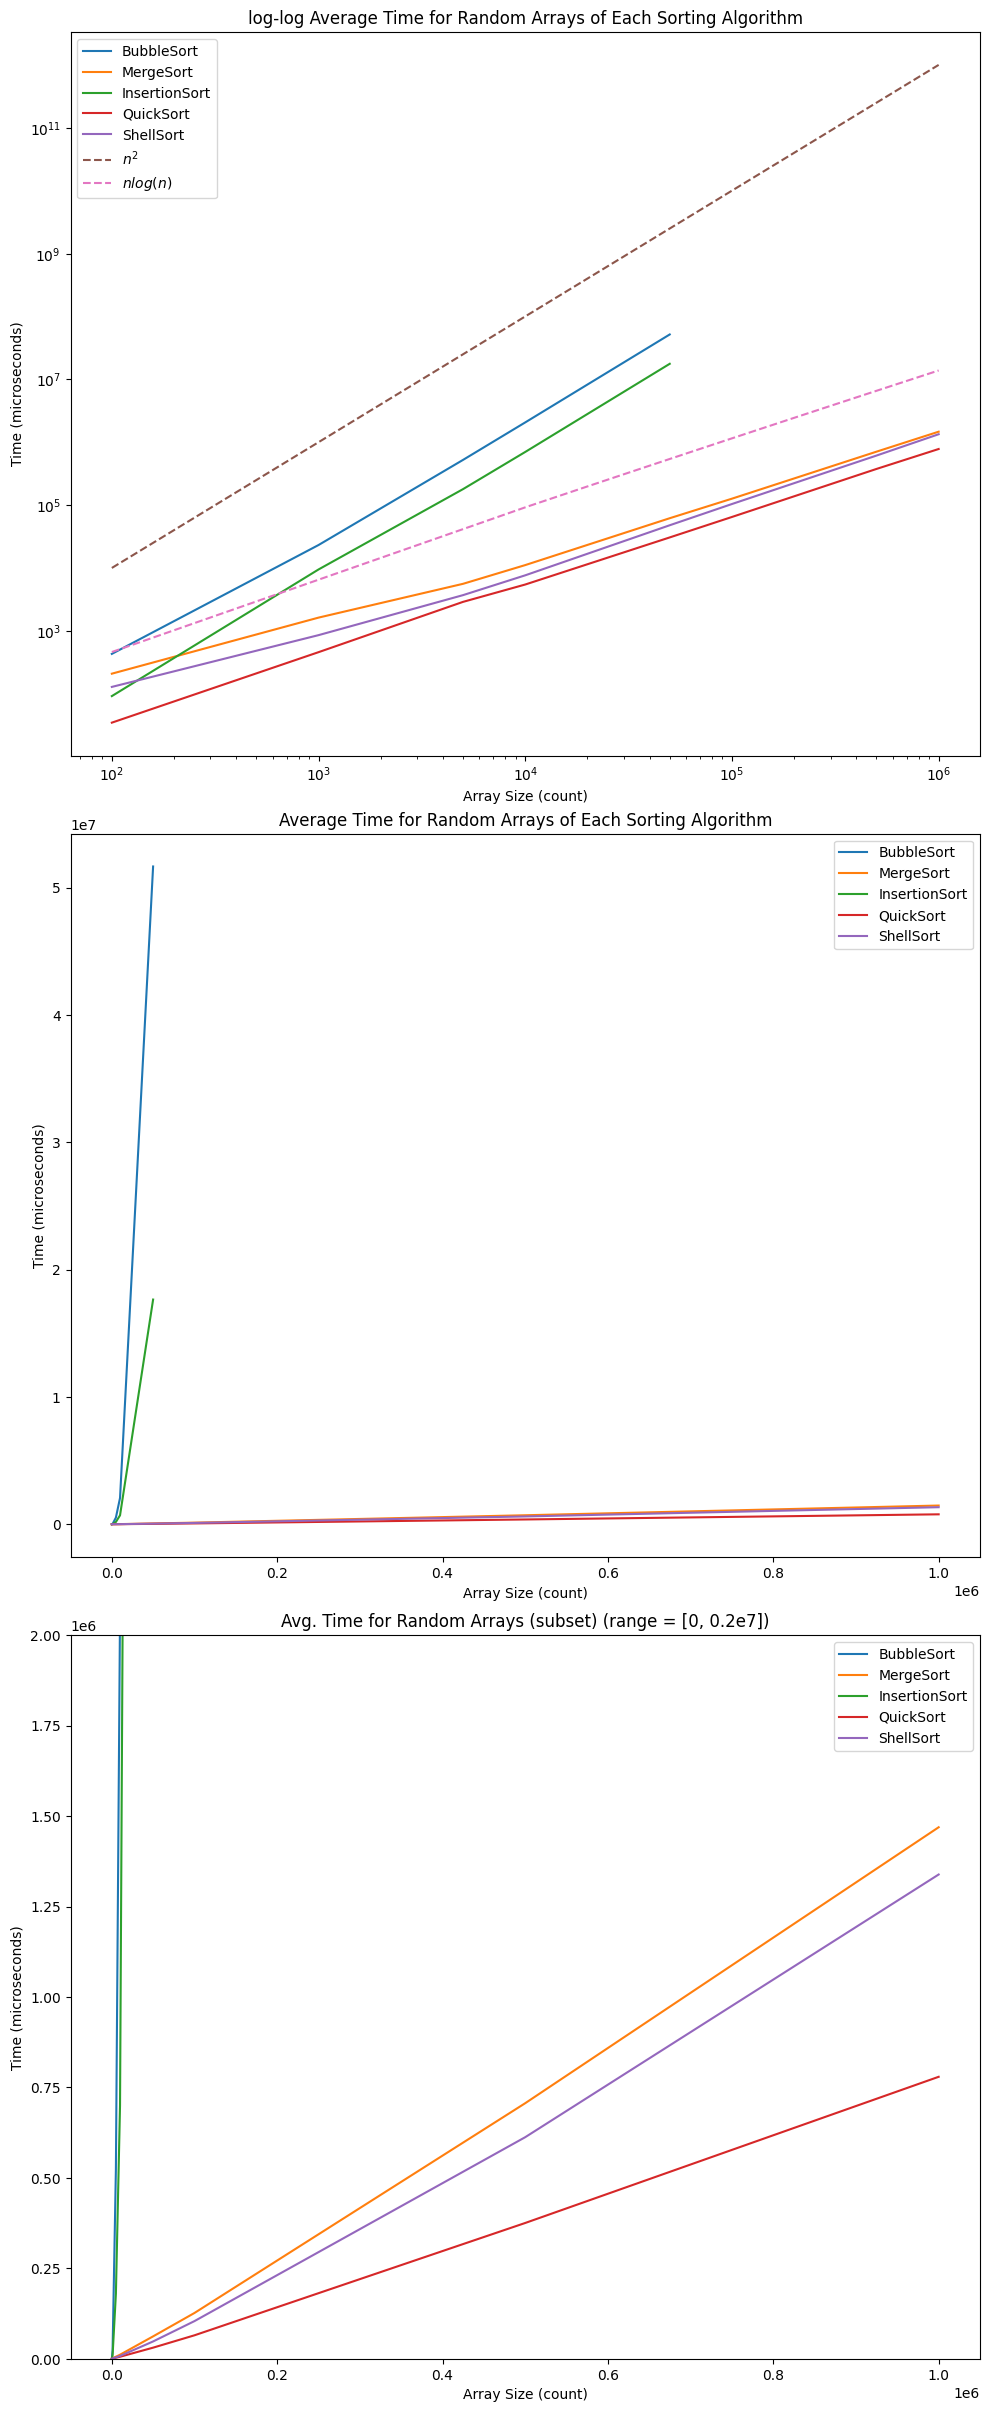

In [6]:
averages = {
    'BubbleSort': bubblesort_avg,
    'MergeSort': mergesort_avg,
    'InsertionSort': insertionsort_avg,
    'QuickSort': quicksort_avg,
    'ShellSort': shellsort_avg
}

fig, axs = plt.subplots(3, figsize=(10, 24))

for i, (name, df) in enumerate(averages.items()):
    data = df[df['ArrayType'] == 'random']

    for ax in axs:
        ax.plot(data['Count'], data['Time'], label=name)

# this is specifically to plot n^2 and nlog(n) for reference
min = df['Count'].min()
max = df['Count'].max()
x = np.linspace(min, max, 100)
y = x ** 2
axs[0].plot(x, y, '--', label='$n^2$')
y2 = x * np.log(x)
axs[0].plot(x, y2, '--', label='$nlog(n)$')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Array Size (count)')
axs[0].set_ylabel('Time (microseconds)')
axs[0].legend()
axs[1].set_xlabel('Array Size (count)')
axs[1].set_ylabel('Time (microseconds)')
axs[1].legend()
axs[2].set_xlabel('Array Size (count)')
axs[2].set_ylabel('Time (microseconds)')
axs[2].legend()

plt.tight_layout()

# display the entire graph
axs[0].set_title('log-log Average Time for Random Arrays of Each Sorting Algorithm')
axs[1].set_title('Average Time for Random Arrays of Each Sorting Algorithm')

# for the more efficient algorithms, display a smaller graph where the y-axis is clamped
axs[2].set_title('Avg. Time for Random Arrays (subset) (range = [0, 0.2e7])')
axs[2].set_ylim([0, 0.2e7])

plt.show()

*Note: Three graphs are displayed: one shows the full range of the **y-axis**, another shows only the **y-axis** where
$\text{range} = [0, 0.2e7]$, and a third one shows the same graph on a $log$-$log$ scale.*

## BubbleSort and InsertionSort

Because the graph of BubbleSort is above the graph of InsertionSort, on average it performs worse in terms of time. To find the coefficient $A$ of $f(An^2)$, we can perform linear regression (basic statistics)by depending on time (which is measured in microseconds).

In [7]:
import statsmodels.formula.api as smf
from IPython.display import Math

bubblesort_avg['CountSquared'] = bubblesort_avg['Count'] ** 2
insertionsort_avg['CountSquared'] = insertionsort_avg['Count'] ** 2

bubblesort_model = smf.ols(formula='Time ~ CountSquared', data=bubblesort_avg.loc[bubblesort_avg['ArrayType'] == 'random'])
insertionsort_model = smf.ols(formula='Time ~ CountSquared', data=insertionsort_avg.loc[insertionsort_avg['ArrayType'] == 'random'])

bubblesort_results = bubblesort_model.fit()
insertionsort_results = insertionsort_model.fit()

bubble_Acoeff = bubblesort_results.params['CountSquared']
insertion_Acoeff = insertionsort_results.params['CountSquared']

display(Math(f'BubbleSort f(n) = ({bubble_Acoeff})n^2'))
display(Math(f'InsertionSort f(n) = ({insertion_Acoeff})n^2'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This python code squares each `Count` value (e.g. $100^2 = 10000$), then relates that to the dependant variable `Time`. (In this case, we are still focusing on the `random` array input). 

Because the coefficent $A$ of BubbleSort's function is greater than the coefficent $A$ of InsertionSort's, we can conclude that on average, BubbleSort performs worse than InsertionSort.

What we also need to consider is the line graph of these two algorithms on a $\log$-$\log$ scale. Reference functions are graphed to help determine the general slope. As a general rule of thumb, we can estimate complexity by these rules when analyzing a $\log$-$\log$ graph:

- A graphed function that approximates the function $f(n)=2n$ (e.g. slope of $2$) would lead to a time complexity of $O(n^2)$.
- A graphed function that approximates the function $f(n)=n$  (e.g. slope of $1$) would lead to a time complexity of $O(n log(n))$.
- A graphed function that looks more quadratic would suggest a higher degree $k$ for $O(n^k)$.

For BubbleSort and InsertionSort, we note the general shape of their graphs has the same slope as our reference function for $O(n^2)$. This means that our algorithms do indeed meet the average time complexity of $O(n^2)$.

## MergeSort, QuickSort, and ShellSort

Starting off with the analysis of the $log$-$log$ graph, we can see that QuickSort and MergeSort follows the same slope as $O(n \log n)$. This means that our algorithms do meed the average time complexity of $O(n^2)$.

Interestingly enough, our ShellSort algorithm also follows this general $O(n \log n)$ trend. This specific implementation of ShellSort uses the gap sequence that has been filed under [OEIS A036562](https://oeis.org/A036562), discovered by Prof. Sedgewick in 1982. We can describe this by the equation:

$$ a(n) = 4^{n+1} + 3 \times 2^n + 1; n \ge 0 $$

Additionally, the integer $1$ must be included in this sequence, as it represents the final standard MergeSort.

Looking at our graphs again, ShellSort was, on average, similar to $O(n \log n)$.
Comparing the actual runtimes of these three algorithms, we find that MergeSort performed the worst of the three, followed by ShellSort, and finally, QuickSort.

In [8]:
import statsmodels.api as sm

mergesort_avg['nlogn'] = mergesort_avg['Count'] * np.log(mergesort_avg['Count'])
quicksort_avg['nlogn'] = quicksort_avg['Count'] * np.log(quicksort_avg['Count'])
shellsort_avg['nlogn'] = shellsort_avg['Count'] * np.log(shellsort_avg['Count'])

mergedf = mergesort_avg.loc[mergesort_avg['ArrayType'] == 'random']
quickdf = quicksort_avg.loc[quicksort_avg['ArrayType'] == 'random']
shelldf = shellsort_avg.loc[shellsort_avg['ArrayType'] == 'random']

# constant
merge_x = sm.add_constant(mergedf['nlogn'])
quick_x = sm.add_constant(quickdf['nlogn'])
shell_x = sm.add_constant(shelldf['nlogn'])

# fit model
merge_res = sm.OLS(mergedf['Time'], merge_x).fit()
quick_res = sm.OLS(quickdf['Time'], quick_x).fit()
shell_res = sm.OLS(shelldf['Time'], shell_x).fit()

display(Math(r'MergeSort f(n) = ({})n \log n'.format(merge_res.params['nlogn'])))
display(Math(r'QuickSort f(n) = ({})n \log n'.format(quick_res.params['nlogn'])))
display(Math(r'ShellSort f(n) = ({})n \log n'.format(shell_res.params['nlogn'])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Again, just like we did for the $O(n^2)$ algorithms for BubbleSort and InsertionSort, we performed linear regression on the results from `random` runs.
Paying attention to our coefficients, we can tell that MergeSort's had the highest coefficient (at $0.106$), followed by ShellSort at
$0.093$, and finally QuickSort's at $0.055$.

# Best Case Performances

For these algorithms, we can assume the best case scenario to be the following:

- BubbleSort: An array that is already sorted. Assumed to be linear time of $O(n)$.
- InsertionSort: An array that is already sorted. $O(n)$
- MergeSort: Doesn't matter, as the algorithm will recursively divide itself into arrays of size $1$, and reassemble them. $O(n \log n)$
- QuickSort: Ideally, each recursive run of QuickSort will result in a pivot point that divides the array into two equal halves. $O(n \log n)$
- ShellSort: An array that is already sorted. $O(n \log n)$ - but depends on gap sequence implemented.

# Worse Case Performances

- BubbleSort: An array that is in reverse order, as elements need to always "bubble up." $O(n^2)$
- InsertionSort: An array that is in reverse order. $O(n^2)$
- MergeSort: Doesn't matter, as the algorithm will recursively divide itself into arrays of size $1$, and reassemble them. $O(n \log n)$
- QuickSort: Each selection of the pivot is actually the smallest or largest element in the array. Typically happens on a fully sorted array (either in order or reversed). $O(n^2)$ or similar
- ShellSort: An array that is in reverse order. $O(n^2)$

# Additional Observations

See below for graphs & observations.

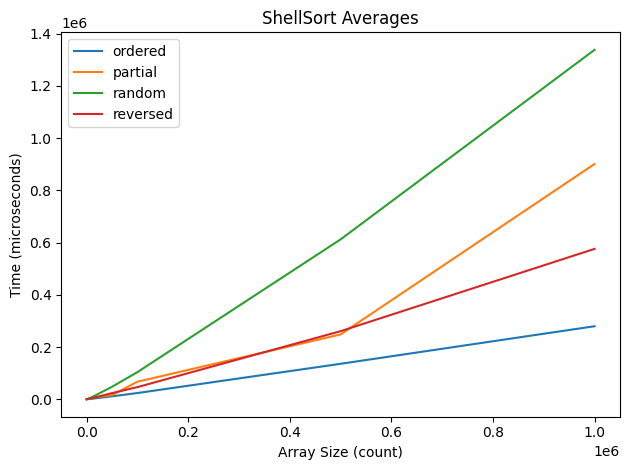

In [9]:
def graph_forav(df, title):
    fig, axs = plt.subplots()

    types = df['ArrayType'].unique()
    for type in types:
        df_subset = df.loc[df['ArrayType'] == type]
        axs.plot(df_subset['Count'], df_subset['Time'], label=type)

    axs.set_xlabel('Array Size (count)')
    axs.set_ylabel('Time (microseconds)')
    axs.legend()

    axs.set_title(title)
    plt.tight_layout()
    plt.show()

graph_forav(shellsort_avg, 'ShellSort Averages')

There were at some points where the time performance of ShellSort on partially ordered arrays was better than the reversed array. This may be due to the way the `partial` array input was implemented, as you could have an arbitrary subset shuffled.

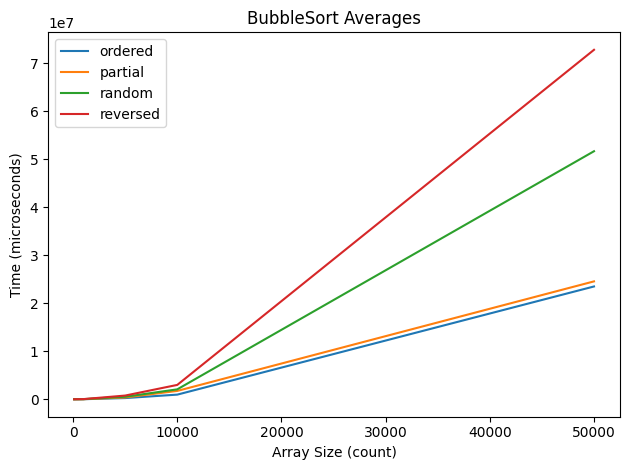

In [10]:
graph_forav(bubblesort_avg, 'BubbleSort Averages')

The `partial` averages were about the same as the `ordered` averages. Again, this may be due to the way that partial arrays were generated.

Additionally, the implementation of BubbleSort is already implemented in a way that a ordered list would only take $n$ operations, and $2n$ operations if only one *pair* of adjacent elements were swapped; meaning, it would take one swap to get a sorted array.

# Tables

These tables are printed here for simplicity's sake.

In [11]:
display(bubblesort_avg.drop('CountSquared', axis=1))
display(insertionsort_avg.drop('CountSquared', axis=1))
display(mergesort_avg.drop('nlogn', axis=1))
display(quicksort_avg.drop('nlogn', axis=1))
display(shellsort_avg.drop('nlogn', axis=1))

,Count,ArrayType,Time
0,100,ordered,1.533333e+02
1,100,partial,2.100000e+02
2,100,random,4.300000e+02
3,100,reversed,3.623333e+02
4,1000,ordered,1.053400e+04
5,1000,partial,1.363267e+04
6,1000,random,2.316033e+04
7,1000,reversed,3.246033e+04
8,5000,ordered,2.472753e+05
9,5000,partial,3.768530e+05


,Count,ArrayType,Time
0,100,ordered,3.000000e+00
1,100,partial,3.333333e+00
2,100,random,9.166667e+01
3,100,reversed,2.213333e+02
4,1000,ordered,3.566667e+01
5,1000,partial,2.620000e+03
6,1000,random,9.465667e+03
7,1000,reversed,1.642767e+04
8,5000,ordered,1.906667e+02
9,5000,partial,9.356933e+04


,Count,ArrayType,Time
0,100,ordered,1.086667e+02
1,100,partial,9.666667e+01
2,100,random,2.083333e+02
3,100,reversed,7.466667e+01
4,1000,ordered,2.155333e+03
5,1000,partial,1.031000e+03
6,1000,random,1.623000e+03
7,1000,reversed,8.440000e+02
8,5000,ordered,4.934667e+03
9,5000,partial,4.981333e+03


,Count,ArrayType,Time
0,100,ordered,7.066667e+01
1,100,partial,8.166667e+01
2,100,random,3.466667e+01
3,100,reversed,6.333333e+01
4,1000,ordered,6.343333e+02
5,1000,partial,6.733333e+02
6,1000,random,4.580000e+02
7,1000,reversed,6.870000e+02
8,5000,ordered,1.913000e+03
9,5000,partial,2.560000e+03


,Count,ArrayType,Time
0,100,ordered,3.633333e+01
1,100,partial,7.133333e+01
2,100,random,1.283333e+02
3,100,reversed,1.210000e+02
4,1000,ordered,2.913333e+02
5,1000,partial,4.276667e+02
6,1000,random,8.543333e+02
7,1000,reversed,4.206667e+02
8,5000,ordered,8.760000e+02
9,5000,partial,2.596000e+03
